<a href="https://colab.research.google.com/github/Yashsharma009/Plant_disease/blob/main/Tomato_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing the ZipFile module
from zipfile import ZipFile

# Define the path to your zip file
zip_file_path = '/content/drive/MyDrive/PlantVillage.zip'

# Define the extraction directory
extracted_dir_path = '/content/yu'

# Open the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents into the specified directory
    zip_ref.extractall(extracted_dir_path)

# Print a message indicating the successful extraction
print(f"Zip file '{zip_file_path}' has been successfully extracted to '{extracted_dir_path}'.")


Zip file '/content/drive/MyDrive/PlantVillage.zip' has been successfully extracted to '/content/yu'.


In [3]:
!pip install tensorflow matplotlib

In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

In [6]:
INIT_LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 5
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = r"/content/yu/PlantVillage"  # Use raw string (r) to handle backslashes in paths
CHANNELS = 3
AUTOTUNE = tf.data.AUTOTUNE


In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = ds.cardinality().numpy()

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 3164 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

3 ['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']


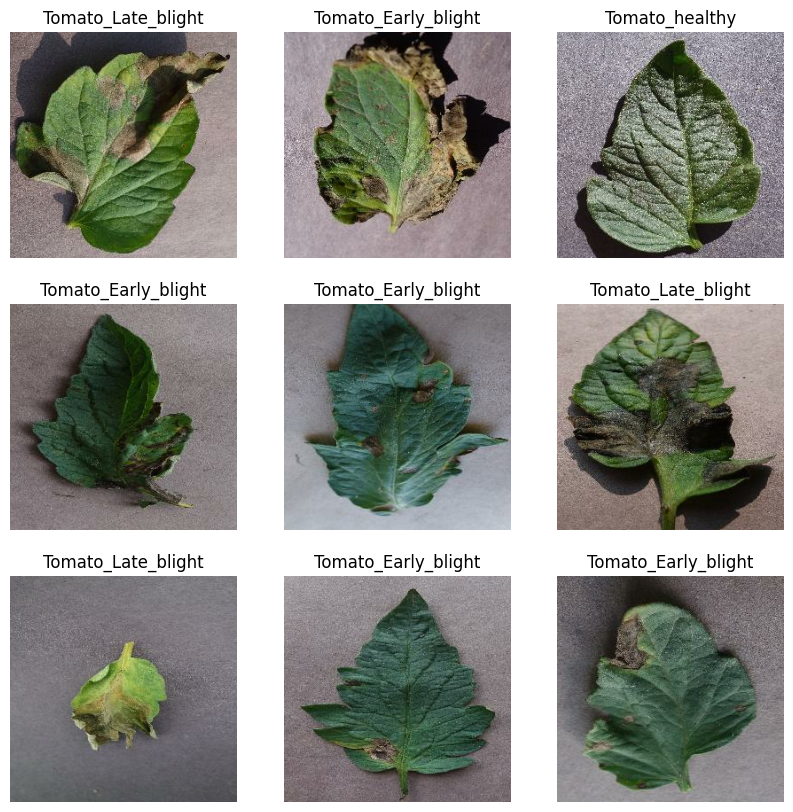

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

In [16]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/5
79/79 [==============================] - 35s 165ms/step - loss: 0.8770 - accuracy: 0.5676 - val_loss: 0.8742 - val_accuracy: 0.5868
Epoch 2/5
79/79 [==============================] - 5s 64ms/step - loss: 0.7412 - accuracy: 0.6748 - val_loss: 0.6620 - val_accuracy: 0.6736
Epoch 3/5
79/79 [==============================] - 5s 64ms/step - loss: 0.5591 - accuracy: 0.7488 - val_loss: 0.6102 - val_accuracy: 0.7535
Epoch 4/5
79/79 [==============================] - 5s 69ms/step - loss: 0.5216 - accuracy: 0.7650 - val_loss: 0.4997 - val_accuracy: 0.8056
Epoch 5/5
79/79 [==============================] - 5s 65ms/step - loss: 0.4065 - accuracy: 0.8275 - val_loss: 0.4293 - val_accuracy: 0.8229


In [20]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
11/11 [==============================] - 3s 29ms/step - loss: 0.4498 - accuracy: 0.8040
Test Accuracy: 80.4%


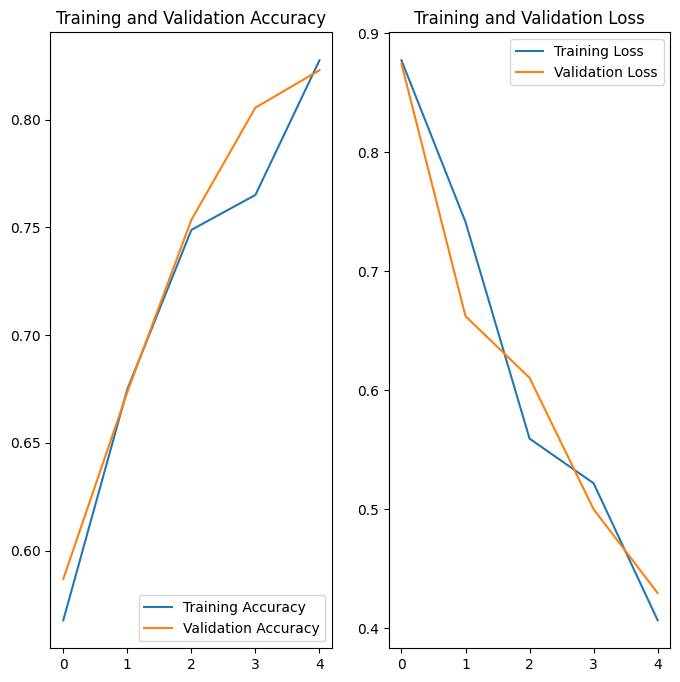

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
# Define a dictionary of disease cures
disease_cures = {
    'tomato_early_blight': 'Apply copper-based fungicides and remove infected leaves.',
    'tomato_late_blight': 'Use fungicides containing chlorothalonil and practice crop rotation.'
}


In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    # Get cure information from the dictionary or provide a default message
    cure_info = disease_cures.get(predicted_class, 'No cure information available.')

    return predicted_class, confidence, cure_info


1/1 [==============================] - 0s 20ms/step


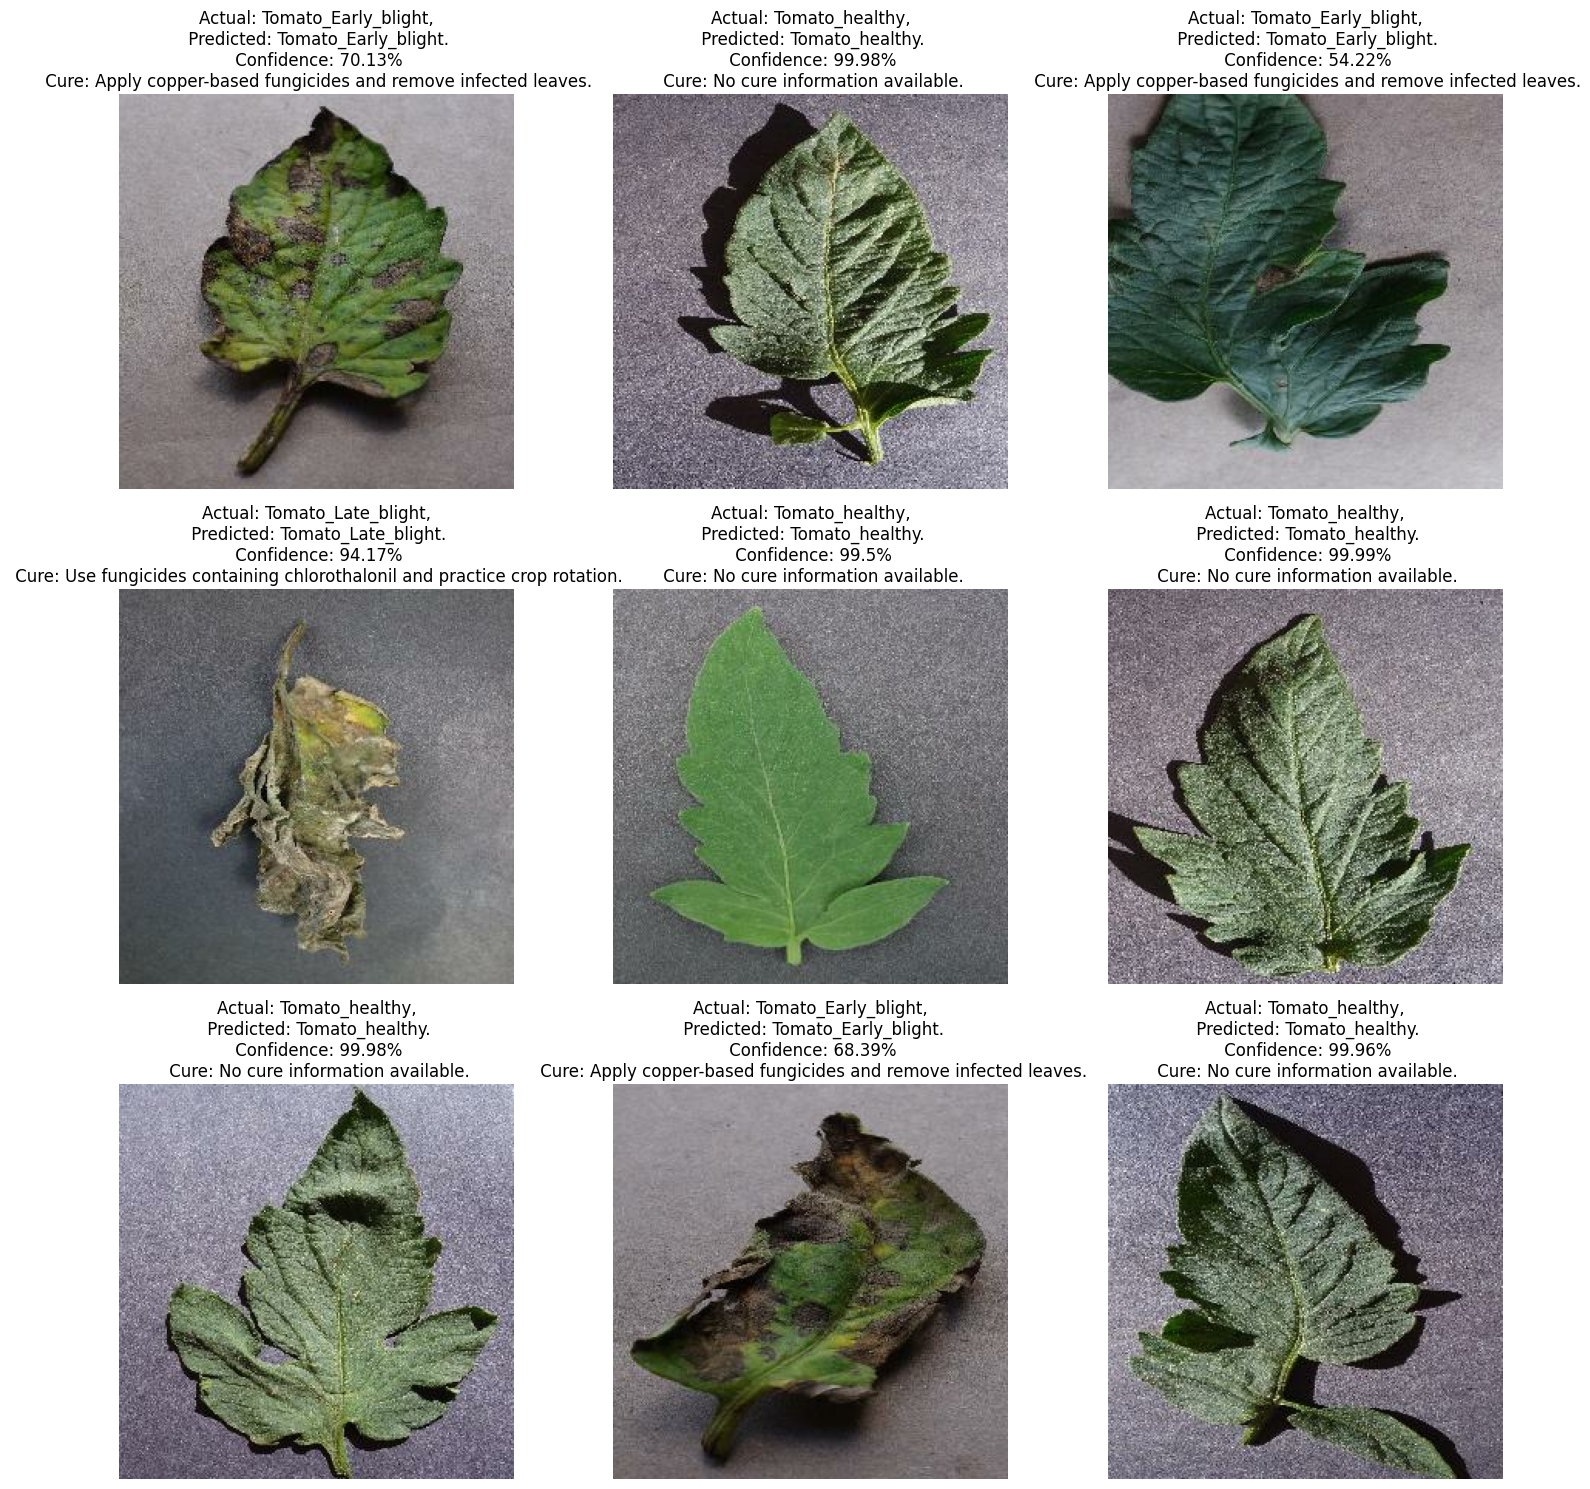

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence, cure_info = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        # Convert predicted class and keys in the dictionary to lowercase with underscores
        predicted_class_key = predicted_class.lower().replace(" ", "_")
        class_names_lower = [class_name.lower().replace(" ", "_") for class_name in class_names]

        # Get cure information from the dictionary or provide a default message
        cure_info = disease_cures.get(predicted_class_key, 'No cure information available.')

        # Display information including cure
        title_text = f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%\n Cure: {cure_info}"

        plt.title(title_text)
        plt.axis("off")

# Automatically adjust subplot parameters to prevent text overlap
plt.tight_layout()
plt.show()
